Import and installing all necessary libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import unidecode
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import bentoml

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\douglas.melo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\douglas.melo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Reading  the dataset 

In [2]:
df= pd.read_csv(r"https://github.com/americanas-tech/b2w-reviews01/raw/main/B2W-Reviews01.csv",delimiter=",",encoding='utf-8')

c:\users\douglas.melo\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG


We will only use two columns, the review text and the rating that the user give to the product

In [4]:
df[['review_text','overall_rating']].head()

,review_text,overall_rating
0,Estou contente com a compra entrega rápida o ú...,4
1,"Por apenas R$1994.20,eu consegui comprar esse ...",4
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,4
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,4
4,"A entrega foi no prazo, as americanas estão de...",5


In [5]:
df = df[['review_text','overall_rating']]

Reviews distribution

In [6]:
df.overall_rating.value_counts()

5    47955
4    32345
1    27369
3    16315
2     8389
Name: overall_rating, dtype: int64

My strategy here is to build a binary classifier using the reviews with 5 and 4  four stars as positive sentiment and 1 and 2 stars as negative sentiment. I'll not use the reviews with 3 stars ratings to predict the neutral class, as sometimes user may give a posititve ou negative review and rate 3 stars. I'll use the probability that the model will give to the text to belong to positive or negative class as a treshold to belong to the neutral sentiment class. When the model is unsure about the positive or negative class , the model will predict as a neutral class. This is used to reduce the model complexity as it behaves as a binary classifier


In [7]:
df['overall_rating'].replace([1,2], 0, inplace=True)
df['overall_rating'].replace([4,5], 1,inplace=True)

In [8]:
df.overall_rating.value_counts()

1    80300
0    35758
3    16315
Name: overall_rating, dtype: int64

Because the classes are unbalanced , I use the undersample strategy 



In [9]:
df_reviews_positive = df[df['overall_rating'] == 1].sample(n=35758,random_state=42)
df_reviews_negative = df[df['overall_rating'] == 0]

In [10]:
df = pd.concat([df_reviews_positive,df_reviews_negative], ignore_index=True)

In [11]:
df.rename(columns={'review_text':'text','overall_rating':'labels'},inplace=True)

In [12]:
df

,text,labels
0,O prazo de entrega foi lindo de ver! E o produ...,1
1,"Ótimo custo beneficio Som de boa qualidade,o c...",1
2,.................................................,1
3,"É um tecido muito bonito, minha sala ficou lin...",1
4,Produto atendeu as expectativas . Recomendo a ...,1
...,...,...
71511,"O produto não tem uma trava para a tampa, quan...",0
71512,"O travesseiro quando colocamos a cabeça, ele f...",0
71513,Infelizmente o Netflix não funciona e esse era...,0
71514,"Material fraco, poderia ser melhor. Ficou deve...",0


Steps to cleaning text:


1.   Removing digits
2.   Removing stop words
3.   lowering the text
4.   Removing especial caracters and word accents




In [13]:
df['text'] = df['text'].str.replace('\d+', '').astype(str)

C:\Users\DOUGLA~1.MEL\AppData\Local\Temp/ipykernel_4700/1761538482.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('\d+', '').astype(str)


In [14]:
stop_words = set(stopwords.words('portuguese'))
stop_words.remove('não')

In [15]:
def pre_processor(text):
  text = text.lower()
  tokenized = word_tokenize(text)
  filtered_sentence = [unidecode.unidecode(word) for word in tokenized if word not in stop_words ]
  return ' '.join(c for c in filtered_sentence if c.isalpha())

In [16]:
df.text = df.text.apply(pre_processor)

Split the data on traning and test

In [17]:
train, test = train_test_split(df, test_size = 0.3, stratify = df['labels'], random_state = 42)

Using Tf-Idf vectorizer to transform raw text into a meaningful representation of numbers

In [18]:
tf = TfidfVectorizer(max_features=1000, preprocessor= pre_processor, ngram_range = (1,2))
tf.fit(train['text'].values)
X_train=tf.transform(train['text'].values)
X_test=tf.transform(test['text'].values)

In [19]:
y_train = train['labels'].values
y_test = test['labels'].values

Testing some classifiers . I'll chose the best for hyperparameter tuning .

In [20]:
# Classifiers 
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, accuracy_score


svm = LinearSVC(tol=1e-05, max_iter=1500)
ridge = RidgeClassifier(alpha=0.8, tol=1e-05)
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
sgd  = SGDClassifier(loss='hinge')
lr = LogisticRegression(solver = 'liblinear', random_state = 42)

In [21]:
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),4))
print("F1: ",round(metrics.f1_score(y_test, y_pred),4))

Accuracy:  0.9309
F1:  0.9298


In [22]:
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),4))
print("F1: ",round(metrics.f1_score(y_test, y_pred),4))

Accuracy:  0.9308
F1:  0.9296


In [23]:
ridge.fit(X_train,y_train)
y_pred = ridge.predict(X_test)
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),4))
print("F1: ",round(metrics.f1_score(y_test, y_pred),4))

Accuracy:  0.9264
F1:  0.9249


In [24]:
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),4))
print("F1: ",round(metrics.f1_score(y_test, y_pred),4))

Accuracy:  0.8357
F1:  0.8174


Tuning the parameters of Logistic Regression with Grid Search to find the best model

In [25]:
lr = LogisticRegression(solver = 'liblinear', random_state = 42)
#lr.fit(X_train,y_train)
#y_pred = lr.predict(X_test)

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

param_grid = [{
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]}
             ]

lr_tfidf = Pipeline([
                     ('clf', LogisticRegression(solver = 'liblinear', random_state = 42))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, scoring='accuracy',
                           cv=5, verbose=1, n_jobs=-1)
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1.0, 10.0, 100.0],
                          'clf__penalty': ['l1', 'l2']}],
             scoring='accuracy', verbose=1)

In [27]:
gs_lr_tfidf.best_params_

{'clf__C': 1.0, 'clf__penalty': 'l1'}

In [28]:
gs_lr_tfidf.best_score_

0.9304847525623801

In [29]:
clf = gs_lr_tfidf.best_estimator_
clf.score(X_test, y_test)

0.9311582381729201

Here , I use Stratified Kfold to find the final model accuracy

In [30]:

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=False)
scores = cross_val_score(LogisticRegression(solver = 'liblinear', random_state = 42,C=1,penalty='l2'), X_train, y_train, cv=cv)
scores

array([0.93328673, 0.92778666, 0.93397922, 0.92828606, 0.92838594])

In [31]:
scores.mean()

0.9303449203610217

Confusion matrix

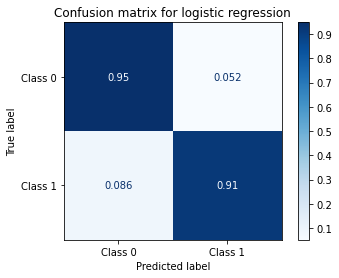

In [32]:
lr.fit(X_train,y_train)
disp = metrics.plot_confusion_matrix(lr, X_test, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Confusion matrix for logistic regression');

Most important words for positive and negative sentiment

In [33]:
feature_importance = lr.coef_[0]
sorted_idx = np.argsort(feature_importance)
top_10_pos_w = [list(tf.vocabulary_.keys())[list(tf.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
top_10_neg_w = [list(tf.vocabulary_.keys())[list(tf.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]

c:\users\douglas.melo\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


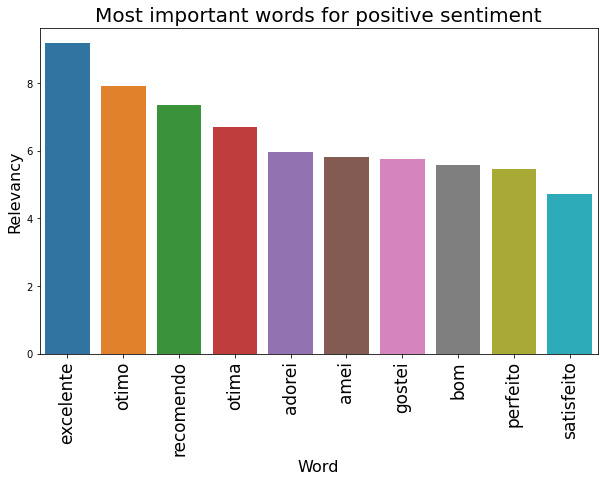

In [34]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_pos_w, feature_importance[sorted_idx[range(-1,-11, -1)]])
plt.title("Most important words for positive sentiment",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.xticks(fontsize=17, rotation=90
          )
plt.ylabel('Relevancy', fontsize = 16)
plt.xlabel('Word', fontsize = 16);

c:\users\douglas.melo\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


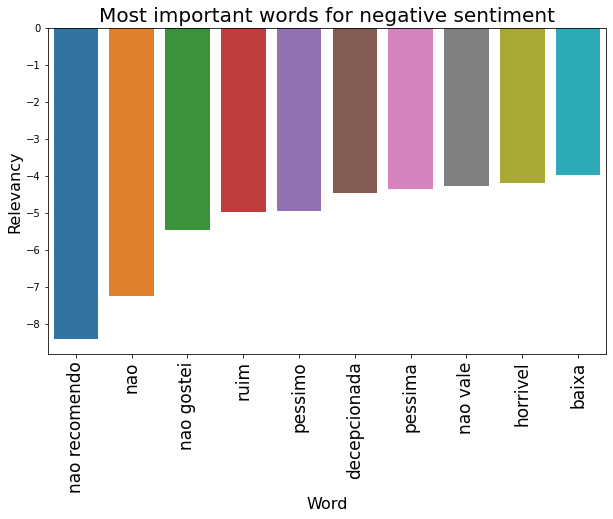

In [35]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_neg_w, feature_importance[sorted_idx[:10]])
plt.title("Most important words for negative sentiment",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.xticks(fontsize=17, rotation=90)
plt.ylabel('Relevancy', fontsize = 16)
plt.xlabel('Word', fontsize = 16);

Testing some comments as example

In [36]:
test_review = tf.transform([pre_processor("""Produto de boa qualidade e  veio dentro do prazo estipulado""")])
lr.predict_proba(test_review)

array([[0.0923626, 0.9076374]])

In [37]:
test_review = tf.transform([pre_processor("""Apesar da demora na entrega, estou satisfeito com o produto""")])
lr.predict_proba(test_review)

array([[0.20443312, 0.79556688]])

In [38]:
test_review = tf.transform([pre_processor("""Não gostei""")])
lr.predict_proba(test_review)

array([[0.94122207, 0.05877793]])

In [39]:
test_review = tf.transform([pre_processor("""Estou com dúvida sobre o produto , qual é o email do atendimento?""")])
lr.predict_proba(test_review)

array([[0.41333996, 0.58666004]])

Function to return the sentiment based on the treshold of 60%.

In [40]:
def Sentiment_classified(prob):
    if prob >= 0.60:
        return 'Negative'
    elif prob <= 0.30:
        return 'Positive'
    else:
        return 'Neutral'

In [41]:
test_review = tf.transform([pre_processor("""Produto de boa qualidade e  veio dentro do prazo estipulado""")])
Sentiment_classified(lr.predict_proba(test_review)[0][0])

'Positive'

In [42]:
X_train=train['text'].values
y_train = train['labels'].values

In [43]:
model = Pipeline([('tf',TfidfVectorizer(max_features=1000, preprocessor= pre_processor, ngram_range = (1,2))),
                     ('clf', LogisticRegression(solver = 'liblinear', random_state = 42,C=1,penalty='l2'))])

In [44]:
model.fit(X_train,y_train)

Pipeline(steps=[('tf',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 2),
                                 preprocessor=<function pre_processor at 0x0000021A2FD0A820>)),
                ('clf',
                 LogisticRegression(C=1, random_state=42, solver='liblinear'))])

In [45]:
model_saved=bentoml.sklearn.save_model("sentiment_analysis",model)
print(f"Model saved: {model_saved}")

Model saved: Model(tag="sentiment_analysis:yotvyb25dcsguxgn")


In [46]:
loaded = bentoml.sklearn.load_model("sentiment_analysis:latest")

In [76]:
loaded[1].predict_proba(loaded[0]\
                        .transform(["""Produto de boa qualidade e  veio dentro do prazo estipulado"""]))

array([[0.09236259, 0.90763741]])

In [48]:
test_review = tf.transform([pre_processor("""Produto de boa qualidade e  veio dentro do prazo estipulado""")])
Sentiment_classified(lr.predict_proba(test_review)[0][0])

'Positive'